In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target,i) for i,target in enumerate(mnist.target[:60000])]))[:,1]
    reorder_test = np.array(sorted([(target,i) for i,target in enumerate(mnist.target[60000:])]))[:,1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
X, y = mnist["data"], mnist["target"]

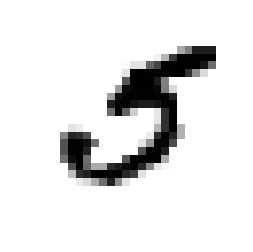

In [5]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap= mpl.cm.binary,
          interpolation="nearest")
plt.axis("off")

plt.show()

In [6]:
# mnistデータをプロットする関数
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
              interpolation="nearest")
    plt.axis("off")

In [7]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)

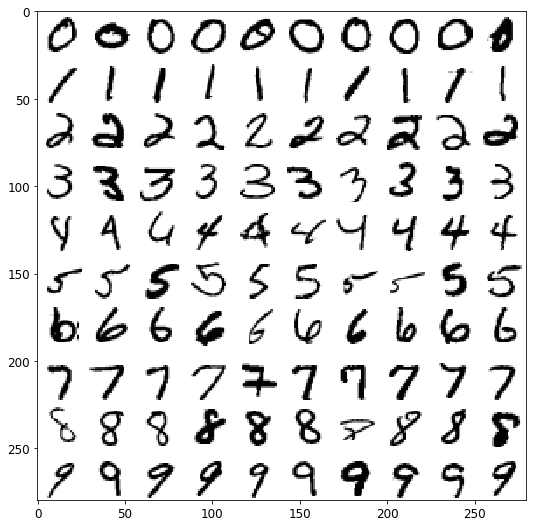

In [8]:
plt.figure(figsize=(9,9))
# 配列の結合
example_images = np.r_[X[:12000:600],X[13000:30600:600],
                      X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [9]:
X_train, X_test, y_train, y_test =X[:60000],X[60000:],y[:60000],y[60000:]

In [10]:
# 訓練セットのシャッフル
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train =X_train[shuffle_index], y_train[shuffle_index]

In [11]:
# 二項分類器
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
# 確率的最急降下法の分類器
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5,tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9502 , 0.96565, 0.96495])

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds =X_train[train_index]
    y_train_folds =(y_train_5[train_index])
    X_test_fold =X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9502
0.96565
0.96495


In [16]:
# すべての画像を5以外クラスに分類するダム分類器の作成
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(selef, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X) ,1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5,cv=3,scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

In [18]:
# K分割交差検証を行う(個々のテストフォールドに対する予測を返す)

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [19]:
# 混同行列を取得する

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]], dtype=int64)

In [20]:
# 分類器が完全である場合
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [21]:
# 適合率
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7687135020350381

In [22]:
# 再現率

recall_score(y_train_5,y_train_pred)

0.801328168234643

In [23]:
# F値( = 2 / {(1 / precision) + 1 / (recall)})

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

In [ ]:
# 決定関数の呼び出し

y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [ ]:
# 閾値を0に設定
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
# 訓練セットのすべてのインスタンスのスコアを計算する
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, 
                            cv=3, method="decision_function")
y_scores.shape

(60000,)

In [ ]:
# hack to work around issue #9589 in Scikit-Learn 0.19.0
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [ ]:
# 可能なあらゆる閾値の適合率と再現率を計算する
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

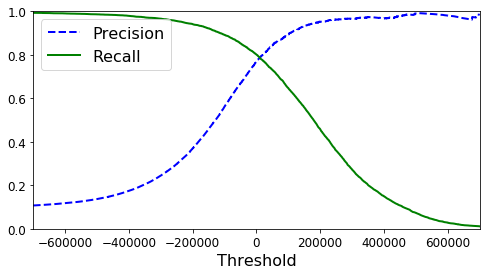

In [ ]:
# 計算した適合率と再現率をプロット
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])
    
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [ ]:
# 90%の適合率(閾値70000)を目指す場合
y_train_pred_90 = (y_scores > 70000)
# 第一引数がy_true, 第二引数がy_pred(スコアが70000以上はtrueと予測)
# 適合率の計算

In [ ]:
# 再現率の計算
recall_score(y_train_5, y_train_pred_90)

0.6993174691016417

In [ ]:
# ROC関数(偽陽性率に対する真陽性率の計算)
from sklearn.metrics import roc_curve
# FPR(偽陽性), TPR(真陽性)
fpr, tpr ,thresholds = roc_curve(y_train_5, y_scores)

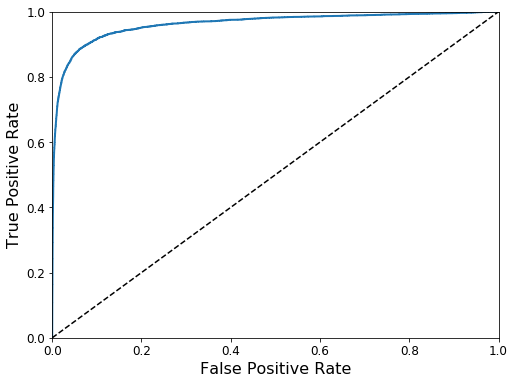

In [ ]:
# ROC曲線をプロットする
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1],[0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate' , fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
# AUC(曲線の下の面積)を計算する
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9624496555967156

In [ ]:
# ランダムフォレスト分類器で訓練する
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
#クラスの分類確率を計算する(predict_probaメソッド)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

In [ ]:
# score = 要請クラスの確率
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

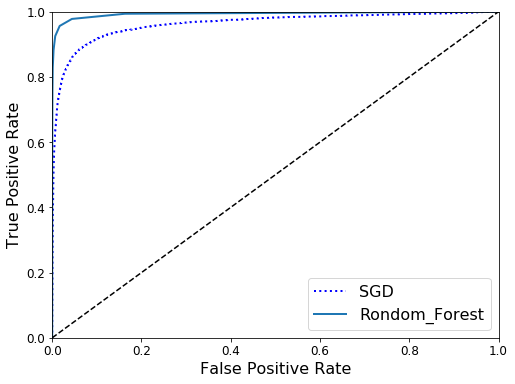

In [ ]:
# SGD分類器とランダムフォレスト分類器のROC曲線をプロットする
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b:', linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Rondom_Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
# ランダムフォレスト分類器のAUCスコアを計算する
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [ ]:
# ランダムフォレスト分類器の適合率を計算する
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [ ]:
# ランダムフォレスト分類器の再現率を計算する
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

In [ ]:
# 0～9のターゲットクラスを使って訓練(SGD)
# 10個の二項分類器を使って訓練し、最も高いスコアのクラスを採用
sgd_clf.fit(X_train, y_train) # y_train_5ではなくy_train
sgd_clf.predict([some_digit]) 

array([5], dtype=int8)

In [ ]:
#それぞれの決定スコアを計算
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-311402.62954431, -363517.28355739, -446449.5306454 ,
        -183226.61023518, -414337.15339485,  161855.74572176,
        -452576.39616343, -471957.14962573, -518542.33997148,
        -536774.63961222]])

In [ ]:
# 最も決定スコアが高い配列のインデックスを返却
np.argmax(some_digit_scores)

5

In [ ]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [ ]:
sgd_clf.classes_[5]

5

In [ ]:
# SGDClassifierを基礎としてOVO法を使った多クラス分類器
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [ ]:
len(ovo_clf.estimators_)

45

In [ ]:
# RandomForestClassifierを基礎としてOVO法を使った多クラス分類器
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [ ]:
# 80%の確率で5を表していると推定している(配列のインデックス5の値が0.8なので)
# 0と3の確率がそれぞれ10%
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0.1, 0. , 0.8, 0. , 0. , 0. , 0. ]])

In [ ]:
# 交差検証で分類器を評価する
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.84063187, 0.84899245, 0.86652998])

In [ ]:
# 入力をスケーリングして評価する
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.91011798, 0.90874544, 0.906636  ])

In [ ]:
# 混同行列の取り出し
y_train_pred= cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5725,    3,   24,    9,   10,   49,   50,   10,   39,    4],
       [   2, 6493,   43,   25,    7,   40,    5,   10,  109,    8],
       [  51,   41, 5321,  104,   89,   26,   87,   60,  166,   13],
       [  47,   46,  141, 5342,    1,  231,   40,   50,  141,   92],
       [  19,   29,   41,   10, 5366,    9,   56,   37,   86,  189],
       [  73,   45,   36,  193,   64, 4582,  111,   30,  193,   94],
       [  29,   34,   44,    2,   42,   85, 5627,   10,   45,    0],
       [  25,   24,   74,   32,   54,   12,    6, 5787,   15,  236],
       [  52,  161,   73,  156,   10,  163,   61,   25, 5027,  123],
       [  43,   35,   26,   92,  178,   28,    2,  223,   82, 5240]],
      dtype=int64)

In [ ]:
# 混同行列のイメージ表現を出力する関数
def plot_confusion_matrix(matrix):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

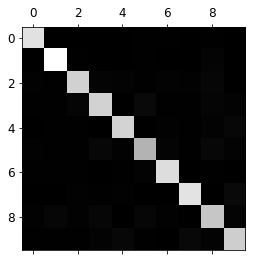

In [ ]:
# 0～9の分類で陽性と分類されたものが白くなる
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# 混同行列の個々の数値を対応するクラスの画像数で割り、誤り率を計算する
row_sums = conf_mx.sum(axis=1, keepdims=True) # 行ごとに要素を合計
norm_conf_mx = conf_mx / row_sums # 誤り率の計算
norm_conf_mx

array([[9.66570994e-01, 5.06500084e-04, 4.05200068e-03, 1.51950025e-03,
        1.68833361e-03, 8.27283471e-03, 8.44166807e-03, 1.68833361e-03,
        6.58450110e-03, 6.75333446e-04],
       [2.96647879e-04, 9.63067339e-01, 6.37792940e-03, 3.70809849e-03,
        1.03826758e-03, 5.93295758e-03, 7.41619697e-04, 1.48323939e-03,
        1.61673094e-02, 1.18659152e-03],
       [8.55991944e-03, 6.88150386e-03, 8.93084928e-01, 1.74555220e-02,
        1.49378986e-02, 4.36388050e-03, 1.46022155e-02, 1.00704935e-02,
        2.78616986e-02, 2.18194025e-03],
       [7.66595988e-03, 7.50285435e-03, 2.29978796e-02, 8.71309737e-01,
        1.63105529e-04, 3.76773773e-02, 6.52422117e-03, 8.15527646e-03,
        2.29978796e-02, 1.50057087e-02],
       [3.25231085e-03, 4.96405341e-03, 7.01814447e-03, 1.71174255e-03,
        9.18521054e-01, 1.54056830e-03, 9.58575830e-03, 6.33344745e-03,
        1.47209860e-02, 3.23519343e-02],
       [1.34661502e-02, 8.30105147e-03, 6.64084117e-03, 3.56022874e-02,
   

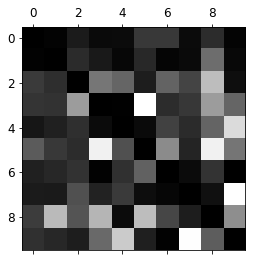

In [ ]:
# 対角線に0をセットし、誤分類のみを表示する
# 行が実際のクラス、列が予測したクラス
# 明るい部分が高誤り率となる
# 例：実際が9なのに7と予測したケースはかなり白い
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

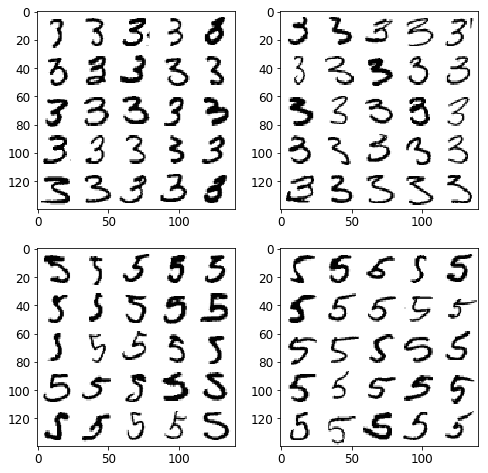

In [ ]:
# 間違えやすい3と5の画像データをプロット

cl_a, cl_b = 3, 5
# 実際は3で、3と予測された数字
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
# 実際は3だが、5と予測されてしまった数字
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
# 実際は5だが、3と予測されてしまった数字
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
# 実際は5で、5と予測された数字
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [ ]:
# 多ラベル分類(複数の2値ラベルを出力する)
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7) # 数字が7より大きいかどうか
y_train_odd = (y_train % 2 == 1) # 数字が奇数かどうか
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [ ]:
# すべてのラベルのF値の平均を計算
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

In [ ]:
# MNIST画像のピクセルの明度にノイズを加えて訓練セットとテストセットを作成
noise = np.random.randint(0,100,(len(X_train), 784))
X_train_mod=X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod =X_test

In [ ]:
# 数字をプロットする
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

In [ ]:
# 画像をクリーンする
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

In [ ]:
# 演習問題1　
from sklearn.model_selection import GridSearchCV

parameter = [
    {'n_neighbors':[3, 5]},
    {'weights':["uniform", "distance"]}
] 
knn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(knn_clf, parameter, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)
grid_search.best_params_
grid_search.best_score_

In [ ]:
# 演習問題2
from scipy.ndimage.interpolation import shift

def shift_px(image, xshift, yshift):
    image = image.reshape((28, 28))
    shift_image = shift(image, [xshift, yshift], cval=0)
    return shift_image

## 